# Time Series Anaysis

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

# Homework: Exploration of the Bay Area Rapid Transit (BART) data 
Bay Area Rapid Transit (BART) is a rapid transit public transportation system serving the San Francisco Bay Area in California. The provided dataset includes daily total ridership records in 2017, 2018, and 2019. In this homework, we aim to use trend + seasonality linear regression to predict BART ridership and detect anomalies using the timeseries decomposition method.

In [2]:
bart = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/bart.csv')

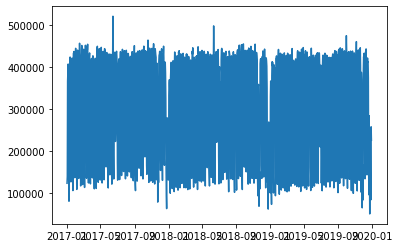

In [3]:
bart['date'] = pd.to_datetime(bart['date'])
plt.plot(bart['date'],bart['passenger'])

### Task 1, use linear regression to explore the trends over 3 years, and report is there a significant trend in the BART data.
Hint: using the index to represent the day count from the first day.

In [4]:
lm=sm.OLS(bart['passenger'],sm.add_constant(bart.index)).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.272
Date:                Sun, 07 Feb 2021   Prob (F-statistic):              0.132
Time:                        16:29:19   Log-Likelihood:                -14433.
No. Observations:                1095   AIC:                         2.887e+04
Df Residuals:                    1093   BIC:                         2.888e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.407e+05   7754.413     43.936      0.0

Based on the linear regression report, as the 95\% confidence interval for the coefficient of X1 varialble (day count) contains zero and the p-value is higher than 5\%, the trend is not statistically siginificant.

### Task 2 Find a proper period using scipy.signal.periodogram and autocorrelation

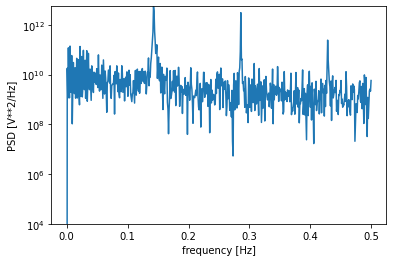

In [5]:
f, PSD = scipy.signal.periodogram(bart.passenger, 1)
plt.semilogy(f, PSD)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim(10**4,max(PSD))
plt.show()

The strongest period is detected at the frequency around 1/7, corresponding to one week.

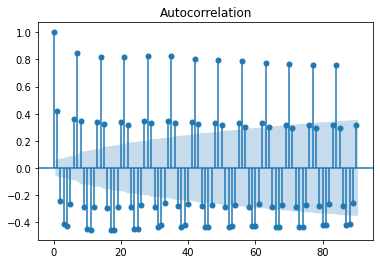

In [6]:
plot_acf(bart.passenger, lags = 90);

Similarly the autocorrelation peaks also correspond to 7,14,21,... days highlighting a one week period

### Task 3 Build a linear regression for trend+seasonality (using a weekly period with 7 dummy variables for each day of the week) to predict passenger count. Train on 2017 and 2018, test on 2019. Visualize the coefficients for each day of the week and analyze their significance

In [7]:
bart['DOW'] = bart['date'].dt.dayofweek
X = pd.concat([pd.DataFrame(range(730),columns=['day']),
               pd.get_dummies(bart['DOW'],drop_first=False)[:730].reset_index(drop=True)],axis=1)
#X = sm.add_constant(X)
lm=sm.OLS(bart.passenger[:730],X).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     512.6
Date:                Sun, 07 Feb 2021   Prob (F-statistic):          3.58e-275
Time:                        16:29:22   Log-Likelihood:                -8961.8
No. Observations:                 730   AIC:                         1.794e+04
Df Residuals:                     722   BIC:                         1.798e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day          -22.1202      9.170     -2.412      0.0

All day of week variables impact BART ridership statistically significant.

<BarContainer object of 7 artists>

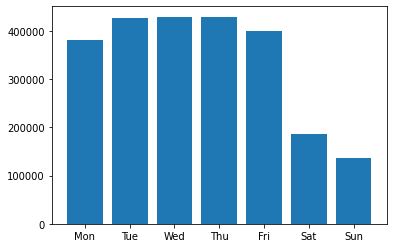

In [8]:
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        lm.params[1:].tolist())

### Task 4, plot results and report insample and out-of-sample predictions. Report in-sample and out-of-sample $R^2$

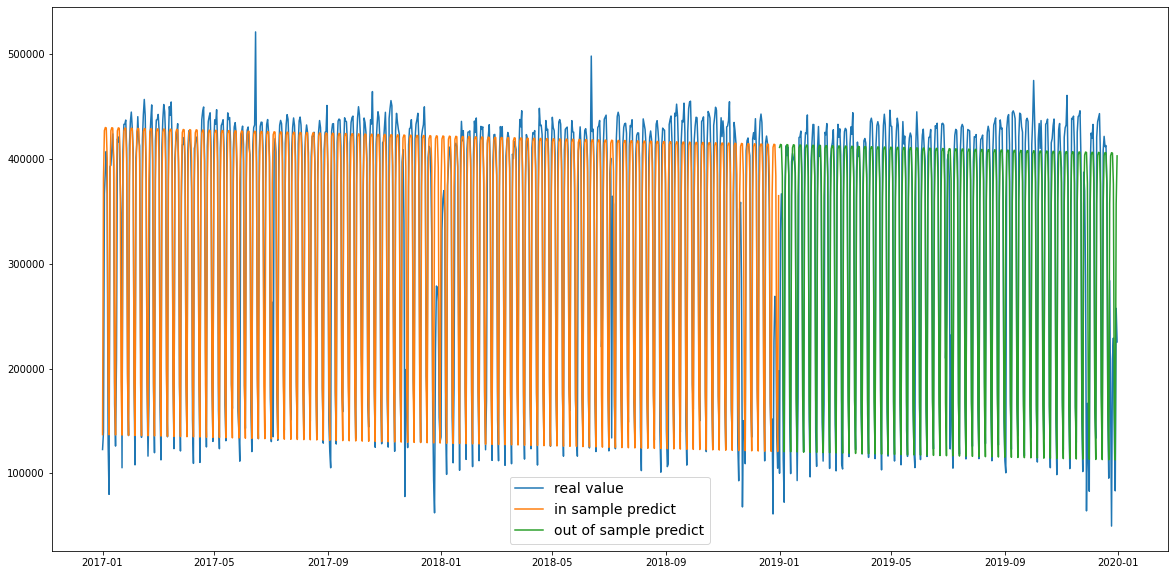

In [9]:
plt.figure(figsize = (20,10))
plt.subplot(111)

plt.plot(bart.date,bart.passenger,label='real value')

inSample = lm.predict(X)
X = pd.concat([pd.DataFrame(range(730,len(bart)),columns=['day']),
               pd.get_dummies(bart['DOW'][730:],drop_first=False).reset_index(drop=True)],axis=1)
#X = sm.add_constant(X)
outofSample = lm.predict(X)

plt.plot(bart.date[:730],inSample,label='in sample predict')
plt.plot(bart.date[730:],outofSample,label='out of sample predict')
plt.legend(fontsize=14)

In [10]:
print('in sample R^2:',r2_score(bart['passenger'][:730],inSample))
print('out of sample R^2:',r2_score(bart['passenger'][730:],outofSample))

in sample R^2: 0.8324941917707158
out of sample R^2: 0.8203089387540557


### Task 5, Use the "multiplicative" seasonal_decompose with 7 day period to decompose the BART data and detect outliers based on the top and bottom 2.5% of the residuals

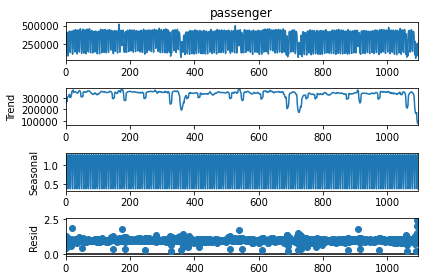

In [11]:
daySeries = bart['passenger']
dailyDecomp = seasonal_decompose(daySeries, model='multicative', freq = 7, extrapolate_trend='freq')
fig = dailyDecomp.plot()

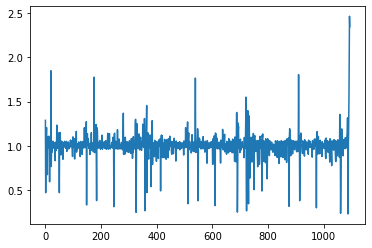

In [12]:
bartResid = dailyDecomp.resid 
plt.plot(bartResid)

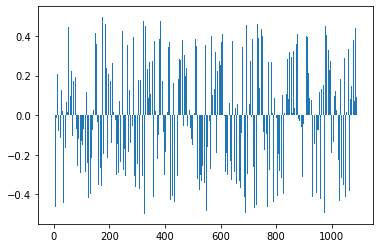

In [13]:
# based on percentile rank
outlierData = pd.DataFrame({})
outlierData['Res'] = bartResid
outlierData['Percentile_rank'] = outlierData.Res.rank(pct = True)-0.5
plt.bar(np.arange(0, len(outlierData)), outlierData['Percentile_rank'])
plt.show()

In [14]:
bart.date[outlierData['Percentile_rank']>0.475]

0      2017-01-01
20     2017-01-21
147    2017-05-28
175    2017-06-25
280    2017-10-08
324    2017-11-21
356    2017-12-23
363    2017-12-30
364    2017-12-31
384    2018-01-20
511    2018-05-27
539    2018-06-24
687    2018-11-19
688    2018-11-20
692    2018-11-24
720    2018-12-22
721    2018-12-23
727    2018-12-29
728    2018-12-30
732    2019-01-03
910    2019-06-30
1058   2019-11-25
1059   2019-11-26
1086   2019-12-23
1091   2019-12-28
1092   2019-12-29
1093   2019-12-30
1094   2019-12-31
Name: date, dtype: datetime64[ns]

In [15]:
bart.date[outlierData['Percentile_rank']<-0.475]

1      2017-01-02
15     2017-01-16
50     2017-02-20
148    2017-05-29
184    2017-07-04
246    2017-09-04
326    2017-11-23
358    2017-12-25
365    2018-01-01
379    2018-01-15
414    2018-02-19
512    2018-05-28
549    2018-07-04
610    2018-09-03
690    2018-11-22
691    2018-11-23
723    2018-12-25
730    2019-01-01
735    2019-01-06
750    2019-01-21
778    2019-02-18
797    2019-03-09
876    2019-05-27
914    2019-07-04
974    2019-09-02
1061   2019-11-28
1088   2019-12-25
Name: date, dtype: datetime64[ns]